# NYC Taxi Dataset 2023 EDA
### Author: Sam Alavi


## Executive Summary

This notebook presents an exploratory data analysis (EDA) of NYC Yellow Taxi trip data from 2023, containing over 34 million records. The analysis focuses on understanding fare patterns, temporal trends, and spatial distributions to inform machine learning model development for fare prediction.

### Dataset Overview
- **Size**: 34,009,543 trips after outlier removal
- **Time Period**: January - December 2023
- **Target Variable**: `fare_amount` (metered base fare, excluding surcharges and tips)
- **Key Features**: Trip distance, temporal features, location IDs, passenger count

### Key Findings

**Temporal Patterns:**
- Clear rush hour effects (7-9 AM, 5-7 PM)
- Weekday vs weekend variations in trip volume and fares
- Monthly seasonality in demand and revenue

**Fare Characteristics:**
- **Mean fare**: $16.78
- **Median fare**: $12.80
- **Strong correlation** with trip distance (r = 0.954)
- Outliers removed using 0.1% and 99.9% quantiles

**Spatial Patterns:**
- Manhattan dominates both pickup and dropoff locations
- Distinct fare patterns across boroughs
- Airport trips (EWR) show different pricing dynamics

**Rush Hour Impact:**
- Rush hours account for 31% of total trips (10.6M vs 23.6M non-rush)
- **Lower average fares during rush hour** ($16.28 vs $17.23 non-rush)
- Likely due to shorter, more congested trips during peak times

### Analysis Structure
1. **Data Quality**: Outlier removal and statistical summaries
2. **Temporal Analysis**: Daily, monthly, weekday, and hourly patterns
3. **Correlation Analysis**: Relationship between fare and distance
4. **Categorical Analysis**: Rush hour and weekend effects
5. **Spatial Analysis**: Borough-level pickup/dropoff patterns

### Next Steps
This EDA informs feature engineering and model selection for fare prediction:
- Use `fare_amount` as target (exclude static surcharges)
- Include temporal features (hour, day of week, month)
- Consider location-based features (borough, zone)
- Model trip distance as primary predictor
- Account for rush hour and weekend effects

---

### Import Libraries

In [41]:
import polars as pl
import pandas as pd

### Load Dataset

- To manage memory efficiently, the dataset is loaded as a **lazy dataframe**
- Lazy evaluation delays computation until explicitly needed (via `.collect()`)
- This approach allows working with large datasets (34M+ rows) without loading everything into memory
- Operations are optimized and executed only when results are required

In [42]:
df = pl.scan_parquet('../data/processed/cleaned_data.parquet', low_memory=True)

### Initial Data Quality Assessment

**Before Outlier Removal:**
- Maximum fare: $386,983.63 (clearly erroneous - likely system error or data entry mistake)
- Maximum trip distance: 17,456.83 miles (impossible for NYC taxi trip)
- High standard deviation indicates presence of extreme outlier

In [43]:
print(df.select(pl.col(['fare_amount', 'trip_distance'])).describe())

shape: (9, 3)
┌────────────┬─────────────┬───────────────┐
│ statistic  ┆ fare_amount ┆ trip_distance │
│ ---        ┆ ---         ┆ ---           │
│ str        ┆ f64         ┆ f64           │
╞════════════╪═════════════╪═══════════════╡
│ count      ┆ 3.4160167e7 ┆ 3.4160167e7   │
│ null_count ┆ 0.0         ┆ 0.0           │
│ mean       ┆ 16.934504   ┆ 2.841214      │
│ std        ┆ 71.700032   ┆ 24.829941     │
│ min        ┆ 0.01        ┆ 0.01          │
│ 25%        ┆ 9.3         ┆ 1.05          │
│ 50%        ┆ 12.8        ┆ 1.71          │
│ 75%        ┆ 19.8        ┆ 3.01          │
│ max        ┆ 386983.63   ┆ 17456.83      │
└────────────┴─────────────┴───────────────┘


**Outlier Removal Strategy:**
- Remove values below 0.1% percentile and above 99.9% percentile
- This eliminates data quality issues while preserving 99.8% of legitimate trips
- Ensures robust analysis and prevents model distortion from anomalous data


In [44]:
def remove_outlier(df: pl.LazyFrame, cols: list, p=0.001):
    for col in cols:
        lower_bound = df.select(pl.col(col).quantile(p))
        higher_bound = df.select(pl.col(col).quantile(1-p))
        df = df.filter(
            (pl.col(col) < higher_bound.collect().item()) &  
            (pl.col(col) > lower_bound.collect().item())
        )
    return df

df = remove_outlier(df, cols=['fare_amount', 'trip_distance'])

print(df.select(pl.col(['fare_amount', 'trip_distance'])).describe())

shape: (9, 3)
┌────────────┬─────────────┬───────────────┐
│ statistic  ┆ fare_amount ┆ trip_distance │
│ ---        ┆ ---         ┆ ---           │
│ str        ┆ f64         ┆ f64           │
╞════════════╪═════════════╪═══════════════╡
│ count      ┆ 3.4009543e7 ┆ 3.4009543e7   │
│ null_count ┆ 0.0         ┆ 0.0           │
│ mean       ┆ 16.782709   ┆ 2.736712      │
│ std        ┆ 11.887123   ┆ 2.917268      │
│ min        ┆ 3.03        ┆ 0.11          │
│ 25%        ┆ 9.3         ┆ 1.05          │
│ 50%        ┆ 12.8        ┆ 1.71          │
│ 75%        ┆ 19.8        ┆ 3.0           │
│ max        ┆ 96.1        ┆ 21.7          │
└────────────┴─────────────┴───────────────┘


### Visualization libraries and setting themes

In [45]:
import seaborn as sns
sns.set_theme(style="darkgrid", 
              palette=sns.color_palette("deep"))

import numpy as np
import matplotlib.pyplot as plt

### Daily Trip Volume Analysis (2023)

**Key Observations:**
- **September 21-25 gap**: Significant drop in trips corresponds to severe weather events (Hurricane Ophelia remnants affected NYC during this period)
- **Summer decline**: Gradual decrease in trip volume during June-August, likely due to:
  - Better weather encouraging walking/cycling
  - Vacation season reducing commuter traffic
  - Residents leaving the city for summer holidays
- **Christmas period drop**: Sharp decline around December 25th reflects reduced business activity and work commutes during the holiday season
- **Red dashed line**: Represents the daily average trip count as a baseline for comparison

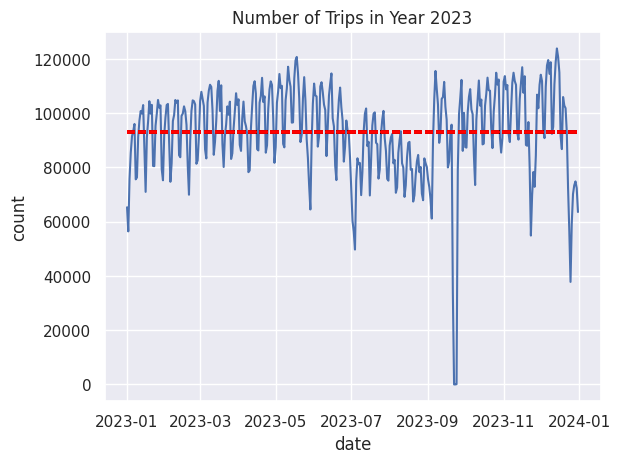

In [46]:
trip_trend = df.select(
    pl.col("tpep_pickup_datetime").dt.strftime("%Y-%m-%d").alias('date'),
    pl.col('fare_amount')
).group_by(pl.col('date')).agg(
    pl.len().alias('count'),
    pl.sum('fare_amount').alias('total_profit')
).collect().to_pandas()

trip_trend['date'] = pd.to_datetime(trip_trend['date'])
trip_trend.sort_values(by='date', inplace=True)

ax = sns.lineplot(data=trip_trend, x='date', y='count',)
ax.hlines(np.repeat(trip_trend['count'].mean(), trip_trend.shape[0]),
          xmin=trip_trend['date'].min(), xmax=trip_trend['date'].max(),
          colors='red', linestyles='--')
ax.set_title('Number of Trips in Year 2023')
plt.show()

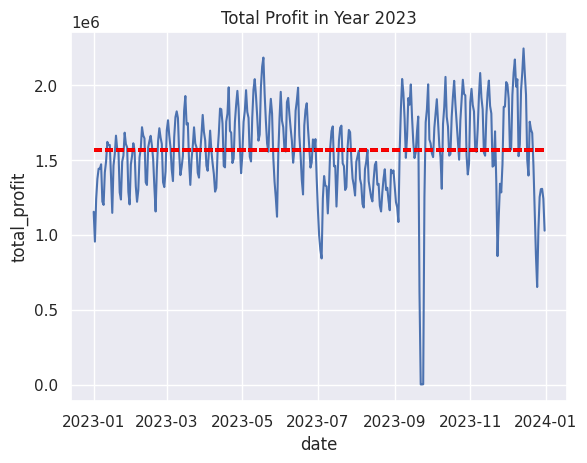

In [47]:
ax = sns.lineplot(data=trip_trend, x='date', y='total_profit',)
ax.hlines(np.repeat(trip_trend['total_profit'].mean(), trip_trend.shape[0]),
          xmin=trip_trend['date'].min(), xmax=trip_trend['date'].max(),
          colors='red', linestyles='--')
ax.set_title('Total Profit in Year 2023')
plt.show()

### Monthly Trip and Fare Analysis

**Trip Volume Patterns:**
- **Peak demand**: March and October show highest trip counts (~3.1M trips each)
- **Lowest demand**: September (2.49M trips) - impacted by Hurricane Ophelia
- **Pattern**: Two peaks in spring (March) and fall (October), with summer dip

**Average Fare Trends:**
- **Progressive increase**: Fares gradually rise throughout the year
- **Lowest fares**: January-February (~$15.94-$16.01) 
- **Highest fares**: September (~$17.84) despite lowest trip volume
- **Fall/Winter**: Consistently higher fares ($17.19-$17.84) from September onward

**Key Insights:**
- **September anomaly**: Lowest trip count but highest average fare suggests:
  - Weather disruptions eliminated short trips
  - Only essential/longer trips were taken during the storm
  - Reduced supply (fewer drivers) may have increased prices
- **Seasonal pattern**: Higher fares in fall/winter likely due to less walking and longer trips

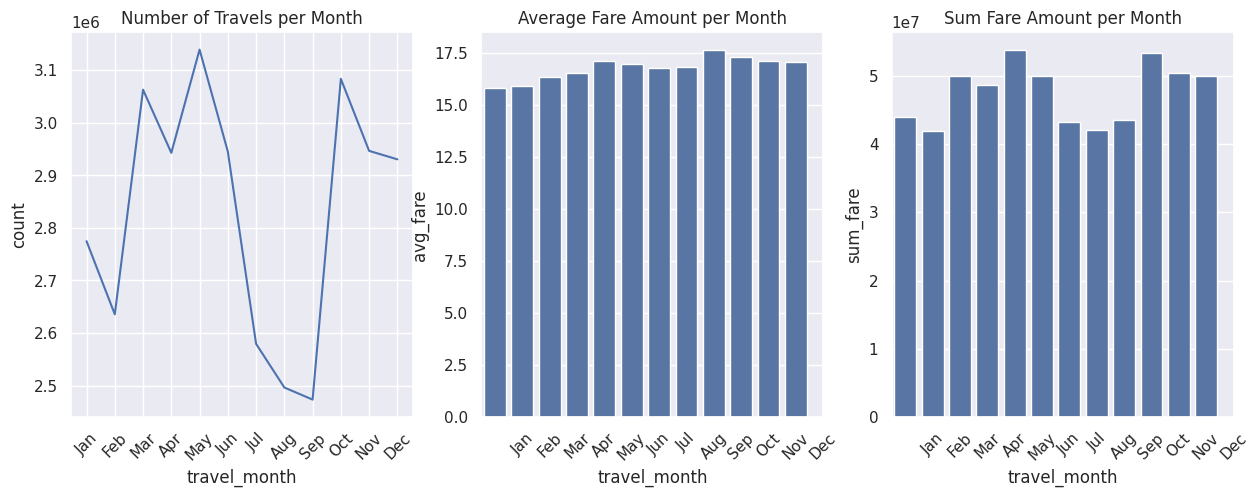

In [72]:
fare_by_month = df.select(
    pl.col('fare_amount'),
    pl.col('travel_month')
).group_by('travel_month').agg(
    pl.col('fare_amount').mean().alias('avg_fare'),
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.len().alias('count')
).collect().to_pandas()


fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
month_labels = [
    'Jan', 'Feb', 'Mar',
    'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep',
    'Oct', 'Nov', 'Dec'
]

# Line plot for count of travels per month
sns.lineplot(data=fare_by_month, x='travel_month', 
             y='count', ax=axes[0])
axes[0].set_title('Number of Travels per Month')

# Bar plot for average fare per month
sns.barplot(data=fare_by_month, x='travel_month',
            y='avg_fare', ax=axes[1])
axes[1].set_title('Average Fare Amount per Month')

# Line plot for total profit per month
sns.barplot(data=fare_by_month, x='travel_month',
            y='sum_fare', ax=axes[2])
axes[2].set_title('Sum Fare Amount per Month')

for ax in axes: 
    ax.set_xticks(range(1, len(month_labels) + 1))
    ax.set_xticklabels(month_labels, rotation=45)
plt.show()

### Weekday Trip Patterns

**Trip Volume by Day:**
- **Lowest demand**: Sunday (4.24M) and Monday (4.21M trips)
- **Peak demand**: Thursday (5.38M trips) - highest trip count
- **Weekday pattern**: Gradual increase from Monday → Thursday, then decline into weekend
- **Weekend effect**: Saturday (5.00M) maintains relatively high volume, Sunday drops significantly

**Average Fare Trends:**
- **Highest fares**: Thursday ($17.25) and Sunday ($17.10)
- **Lowest fares**: Saturday ($16.26) - 6% lower than Thursday
- **Weekday stability**: Monday-Thursday maintain consistent fares (~$17.01-$17.25)
- **Friday drop**: Begins weekend fare decline ($16.81)

**Key Insights:**
- **Monday pattern**: Post-pandemic remote work culture likely reduces Monday commutes
- **Thursday peak**: Highest activity as people complete work-week commitments before Friday
- **Saturday discount**: Lower fares despite high trip volume suggest shorter, non-commute trips (entertainment, shopping)
- **Sunday characteristics**: Lowest volume but higher fares indicate longer, more purposeful trips

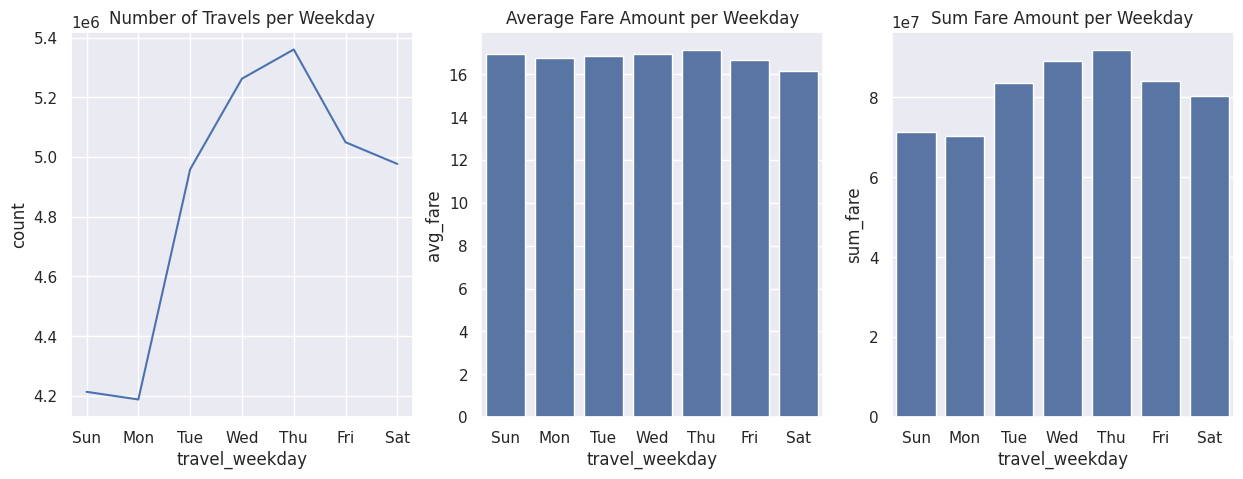

In [ ]:
weekday_labels = [
    'Sun', 'Mon', 'Tue', 'Wed',
    'Thu', 'Fri', 'Sat'
]

fare_by_weekday = df.select(
    pl.col('fare_amount'),
    pl.col('travel_weekday')
).group_by('travel_weekday').agg(
    pl.col('fare_amount').mean().alias('avg_fare'),
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.len().alias('count')
).collect().to_pandas()


fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

# Line plot for count of travels per Weekday
sns.lineplot(data=fare_by_weekday, x='travel_weekday', 
             y='count', ax=axes[0])
axes[0].set_title('Number of Travels per Weekday')

# Bar plot for average fare per Weekday
sns.barplot(data=fare_by_weekday, x='travel_weekday',
            y='avg_fare', ax=axes[1])
axes[1].set_title('Average Fare Amount per Weekday')

# Line plot for total profit per Weekday
sns.barplot(data=fare_by_weekday, x='travel_weekday',
            y='sum_fare', ax=axes[2])
axes[2].set_title('Sum Fare Amount per Weekday')

for ax in axes:
    ax.set_xticks(range(0, len(weekday_labels)))
    ax.set_xticklabels(weekday_labels)

plt.show()

### Day of Month Analysis

**Trip Volume Pattern (Left Plot):**
- **Days 1-25**: Consistent trip volume (~1.1-1.2M trips per day)
- **Days 26-31**: Significant decline, especially days 29-31 (drops to ~0.6-0.8M)
- **Explanation**: This decline is a **data artifact**, not a real pattern:
  - February has only 28 days
  - April, June, September, November have only 30 days
  - Therefore, days 29-31 have fewer months contributing data → artificially lower totals

**Average Fare Pattern (Middle Plot):**
- **No meaningful pattern**: Fares remain consistent across all days (~$16.50-$17.50)
- **Key insight**: Day of month has no predictive value for fare amounts
- This confirms that fare pricing is driven by time-of-day, location, and distance—not calendar date

**Sum Fare Pattern (Right Plot):**
- Mirrors the trip count pattern (left plot) for the same reasons

**Conclusion:** Day of month is **not a useful feature** for fare prediction modeling. Focus should remain on weekday, hour, month, and location-based features.

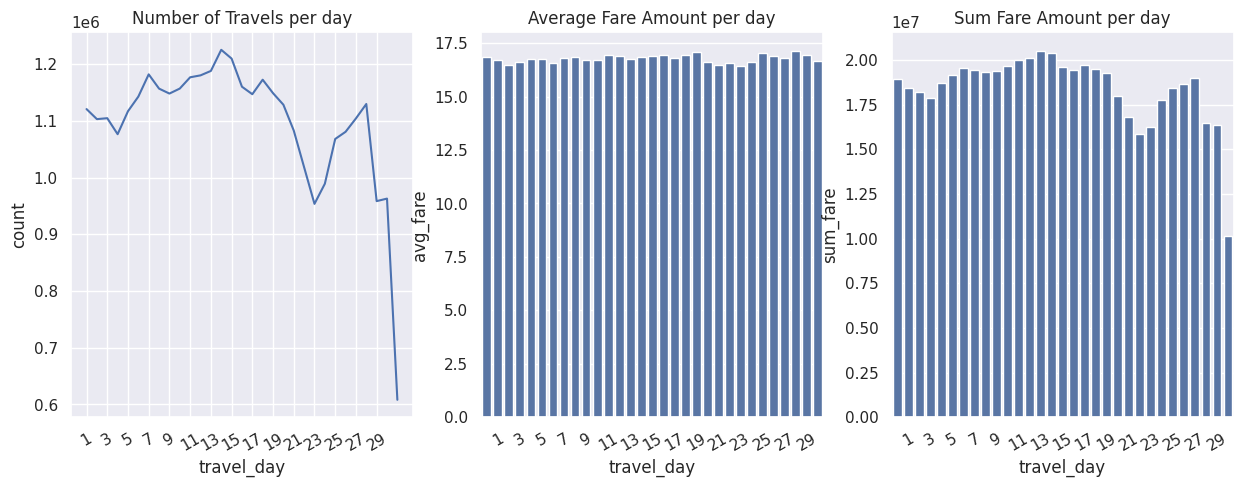

In [68]:
fare_by_day = df.select(
    pl.col('fare_amount'),
    pl.col('travel_day')
).group_by('travel_day').agg(
    pl.col('fare_amount').mean().alias('avg_fare'),
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.len().alias('count')
).collect().to_pandas()


fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

# Line plot for count of travels per day
sns.lineplot(data=fare_by_day, x='travel_day', 
             y='count', ax=axes[0])
axes[0].set_title('Number of Travels per day')

# Bar plot for average fare per day
sns.barplot(data=fare_by_day, x='travel_day',
            y='avg_fare', ax=axes[1])
axes[1].set_title('Average Fare Amount per day')

# Line plot for total profit per day
sns.barplot(data=fare_by_day, x='travel_day',
            y='sum_fare', ax=axes[2])
axes[2].set_title('Sum Fare Amount per day')

for ax in axes:
    ax.set_xticks(range(1, 31, 2))
    ax.set_xticklabels(range(1, 31, 2), rotation=30)

plt.show()

### Hourly Trip Patterns

**Trip Volume by Hour (Left Plot):**
- **Overnight low**: 4-5 AM shows lowest demand (~500K trips)
- **Morning rush**: 7-9 AM surge, peaking around 8-9 AM
- **Lunch peak**: Slight increase around noon-1 PM
- **Evening rush**: 5-7 PM shows highest demand (~1.8M trips at 6 PM)
- **Late evening**: Gradual decline after 8 PM, but remains elevated until midnight

**Average Fare by Hour (Middle Plot):**
- **Highest fares**: Early morning hours 4-6 AM (~$17.50+) - likely longer trips, airport runs
- **Rush hour paradox**: 7-9 AM and 5-7 PM show slightly lower fares despite high demand
- **Afternoon**: 12 PM - 4 PM maintains moderate fares (~$16.50-$17.00)
- **Late night premium**: After 10 PM fares increase, peaking in early morning

**Key Insights:**
- **Demand-fare disconnect**: Highest demand doesn't correlate with highest fares
- **Early morning premium**: 4-6 AM trips are longer and more expensive (airport, shift workers)
- **Rush hour efficiency**: Despite congestion, rush hour trips are shorter in distance
- **Time-of-day is critical**: Hour is a strong predictor for both volume and fare patterns

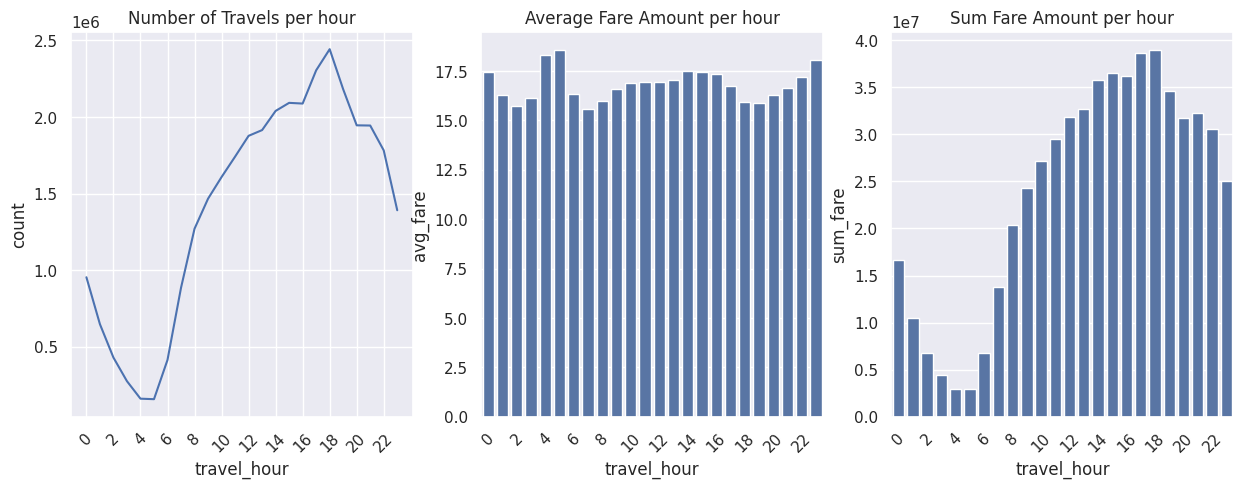

In [71]:
fare_by_hour = df.select(
    pl.col('fare_amount'),
    pl.col('travel_hour')
).group_by('travel_hour').agg(
    pl.col('fare_amount').mean().alias('avg_fare'),
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.len().alias('count')
).collect().to_pandas()


fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

# Line plot for count of travels per hour
sns.lineplot(data=fare_by_hour, x='travel_hour', 
             y='count', ax=axes[0])
axes[0].set_title('Number of Travels per hour')

# Bar plot for average fare per hour
sns.barplot(data=fare_by_hour, x='travel_hour',
            y='avg_fare', ax=axes[1])
axes[1].set_title('Average Fare Amount per hour')

# Line plot for total profit per hour
sns.barplot(data=fare_by_hour, x='travel_hour',
            y='sum_fare', ax=axes[2])
axes[2].set_title('Sum Fare Amount per hour')

for ax in axes:
    ax.set_xticks(range(0, 24, 2))
    ax.set_xticklabels(range(0, 24, 2), rotation=45)

plt.show()

### Correlation Analysis: Fare Amount vs Trip Distance

**Correlation Coefficient: 0.954**

This represents a **very strong positive linear relationship** between trip distance and fare amount.

**Interpretation:**
- 95.4% correlation indicates trip distance is the dominant factor in fare calculation
- This aligns with NYC taxi meter structure:
  - Base fare calculation uses distance-based rate ($2.50 per mile)
  - Time-based rate applies only when speed < 12 mph
  - Result: Distance is primary fare determinant

**For Machine Learning:**
- Trip distance will be the **most important predictor** in any fare prediction model
- The remaining 4.6% variance likely explained by secondary factors:
  - Time of day (rush hour, late night)
  - Traffic conditions
  - Route efficiency
  - Location-based surcharges (airport, congestion zones)

In [52]:
df.select(
    pl.corr(
        'fare_amount',
        'trip_distance',
    )
).collect()

fare_amount
f64
0.95391


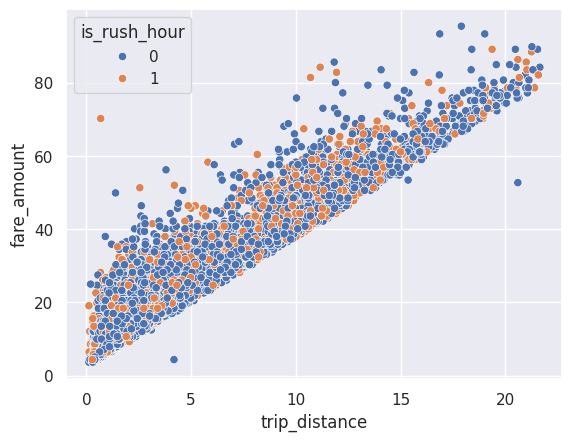

In [73]:
trip_fare = df.select(
    pl.col([
        'fare_amount',
        'trip_distance',
        'is_rush_hour',
        'is_weekend'
    ])
).collect().sample(fraction=0.001).to_pandas()

sns.scatterplot(data=trip_fare, x='trip_distance', y='fare_amount', hue='is_rush_hour')
plt.show()

### Rush Hour Impact Analysis

**Trip Volume (Middle Plot):**
- **Non-rush hours (0)**: 23.6M trips - 69% of all trips
- **Rush hours (1)**: 10.6M trips - 31% of all trips
- Rush hours (7-9 AM, 5-7 PM) represent only 6 hours per day but account for nearly 1/3 of daily trips

**Average Fare (Right Plot):**
- **Non-rush hours (0)**: $17.23 average fare
- **Rush hours (1)**: $16.28 average fare
- **Surprising result**: Rush hour fares are **$0.95 lower** (5.5% decrease)

**Total Revenue (Left Plot):**
- **Non-rush hours (0)**: $406M total revenue
- **Rush hours (1)**: $172M total revenue

**Key Insight:**
Rush hour trips have **lower average fares** despite higher demand. This counter-intuitive finding suggests:
- Rush hour trips are shorter in distance (commute trips within city)
- Traffic congestion doesn't increase fares enough to offset shorter distances
- Non-rush trips include more airport runs and longer-distance journeys

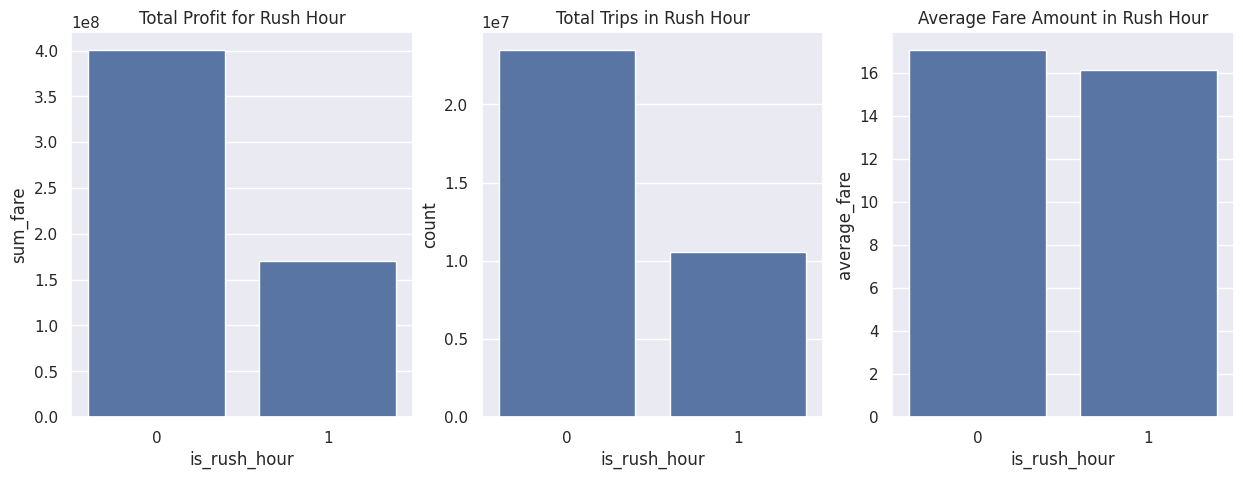

In [54]:
rush_hour_agg = df.select(
    pl.col([
        'is_rush_hour',
        'fare_amount'
    ])
).group_by('is_rush_hour').agg(
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.len().alias('count'),
    pl.col('fare_amount').mean().alias('average_fare')
).collect().to_pandas()

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

sns.barplot(rush_hour_agg, x='is_rush_hour', y='sum_fare', ax=axes[0])
axes[0].set_title('Total Profit for Rush Hour')

sns.barplot(rush_hour_agg, x='is_rush_hour', y= 'count', ax=axes[1])
axes[1].set_title('Total Trips in Rush Hour')

sns.barplot(rush_hour_agg, x='is_rush_hour', y='average_fare', ax=axes[2])
axes[2].set_title('Average Fare Amount in Rush Hour')

plt.show()


### Pickup Location Analysis by Borough

**Trip Volume (Right Plot):**
- **Manhattan dominates**: 30.6M trips (90% of all pickups)
- **Queens**: 2.1M trips (6% of pickups)
- **Other boroughs**: Minimal pickup activity (<1% each)
- **Explanation**: NYC yellow taxis are primarily licensed to pick up street hails in Manhattan and airports

**Average Fare by Pickup Location (Left Plot):**
- **Highest fares**:
  - **Queens**: $43.34 - includes JFK and LaGuardia airport pickups (long-haul trips)
  - **EWR** (Newark): $37.91 - airport trips to NYC
- **Manhattan**: $14.81 - lowest fares due to short intra-borough trips
- **Bronx**: $22.32 - medium-distance trips
- **Brooklyn**: $22.05 - cross-borough commutes

**Key Insights:**
- **Airport effect**: Queens and EWR command 2-3x higher fares due to long-distance airport trips
- **Manhattan paradox**: Highest trip volume but lowest average fare (short distances within the borough)
- **Regulatory context**: Yellow taxi pickup restrictions create concentrated Manhattan demand
- **For ML modeling**: Pickup borough is a strong fare predictor, especially for airport zones

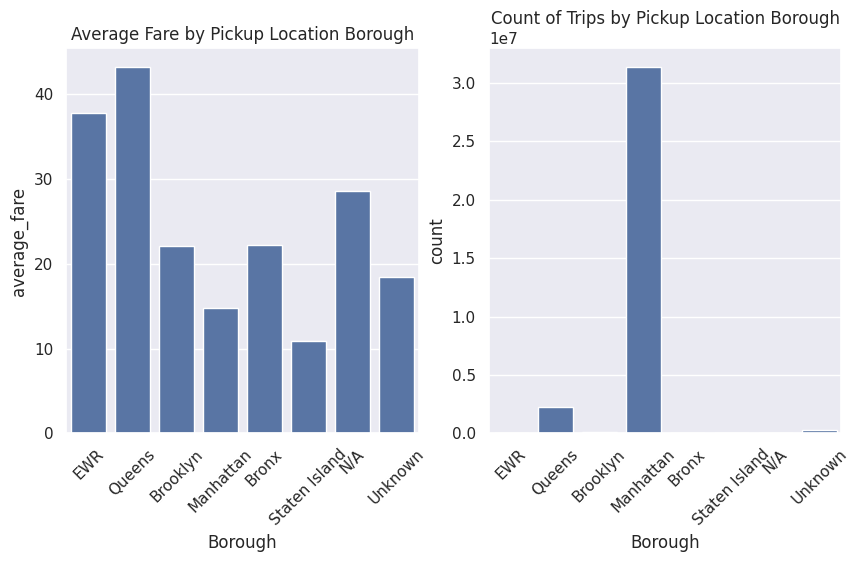

In [55]:

pickup_stats = df.select(
    pl.col([
        'PULocationID',
        'fare_amount',
        'trip_distance'
    ])
).join(
    pl.scan_csv('../data/lookups/taxi_zone_lookup.csv'),
    left_on='PULocationID',
    right_on='LocationID'
).group_by('Borough').agg(
    pl.col('fare_amount').mean().alias('average_fare'),
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.col('trip_distance').mean().alias('average_distance'),
    pl.len().alias('count')
).collect().to_pandas()


fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

sns.barplot(pickup_stats, x='Borough', y='average_fare', ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Average Fare by Pickup Location Borough')

sns.barplot(pickup_stats, x='Borough', y='count', ax=axes[1])
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Count of Trips by Pickup Location Borough')
plt.show()


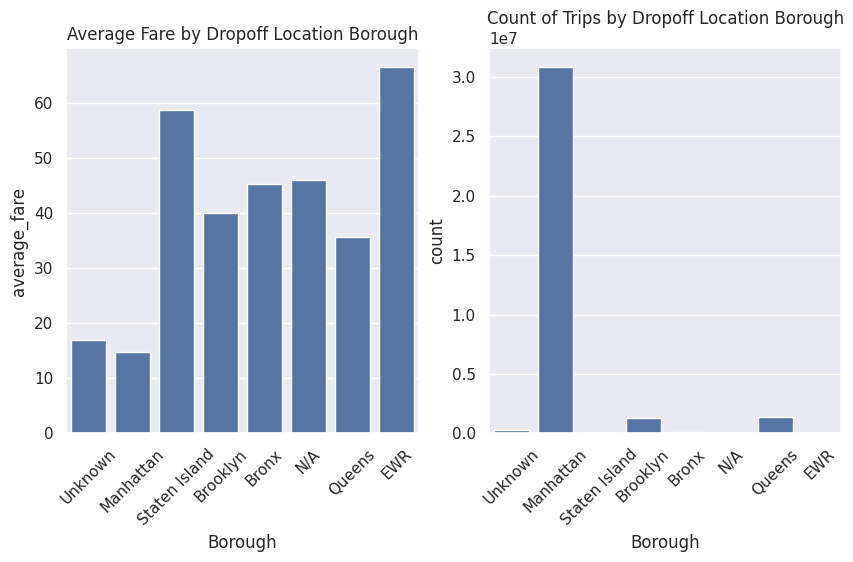

In [56]:

dropoff_stats = df.select(
    pl.col([
        'DOLocationID',
        'fare_amount',
        'trip_distance'
    ])
).join(
    pl.scan_csv('../data/lookups/taxi_zone_lookup.csv'),
    left_on='DOLocationID',
    right_on='LocationID'
).group_by('Borough').agg(
    pl.col('fare_amount').mean().alias('average_fare'),
    pl.col('fare_amount').sum().alias('sum_fare'),
    pl.col('trip_distance').mean().alias('average_distance'),
    pl.len().alias('count')
).collect().to_pandas()


fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

sns.barplot(dropoff_stats, x='Borough', y='average_fare', ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Average Fare by Dropoff Location Borough')

sns.barplot(dropoff_stats, x='Borough', y='count', ax=axes[1])
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Count of Trips by Dropoff Location Borough')
plt.show()


In [57]:
from plotly.graph_objects import go

go.

SyntaxError: invalid syntax (2136235579.py, line 3)